In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

In [3]:
import numpy as np
import random
import os

In [4]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import accuracy_score

In [5]:
SEED = 28
img_sz = 128
DATA_PATH = "../data/astro_dataset_maxia/astro_dataset_maxia"

In [6]:
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [7]:
blur_transform = mega_transform = transforms.Compose([
    transforms.Resize((img_sz, img_sz)),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])

bright_transform = mega_transform = transforms.Compose([
    transforms.Resize((img_sz, img_sz)),
    transforms.ColorJitter(0.4, 0.6),
    transforms.ToTensor()
])

mega_transform = transforms.Compose([
    transforms.Resize((img_sz, img_sz)),
    transforms.ColorJitter(0.4, 0.6),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])

transformations = [blur_transform, bright_transform, mega_transform]

In [8]:
TRAIN_PATH = os.path.join(DATA_PATH, "training")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [9]:
def dataset_to_numpy(group_of_images):
    X_list, y_list = [], []
    for img, label in group_of_images:
        arr = img.numpy().reshape(-1)
        y_list.append(label)
        X_list.append(arr)
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

In [12]:
data = [None for _ in range(len(transformations))]

for i in range(len(transformations)):
    transformation = transformations[i]
    train_group = datasets.ImageFolder(TRAIN_PATH, transform=transformation)
    val_group   = datasets.ImageFolder(VAL_PATH,   transform=transformation)
    test_group  = datasets.ImageFolder(TEST_PATH,  transform=transformation)

    class_names = train_group.classes
    num_classes = len(class_names)
    X_train, y_train = dataset_to_numpy(train_group)
    X_val,   y_val   = dataset_to_numpy(val_group)
    X_test,  y_test  = dataset_to_numpy(test_group)

    data[i] = {"X_train": X_train, "X_val": X_val, "X_test": X_test,
        "y_train": y_train, "y_val": y_val, "y_test": y_test}

data

[{'X_train': array([[0.49019608, 0.49019608, 0.49803922, ..., 0.24313726, 0.24313726,
          0.23921569],
         [0.04313726, 0.04313726, 0.03921569, ..., 0.52156866, 0.5254902 ,
          0.5254902 ],
         [0.02352941, 0.02352941, 0.01960784, ..., 0.30980393, 0.30980393,
          0.30980393],
         ...,
         [0.01176471, 0.00392157, 0.00784314, ..., 0.        , 0.        ,
          0.        ],
         [0.01176471, 0.00392157, 0.00784314, ..., 0.        , 0.        ,
          0.        ],
         [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
          0.        ]], shape=(2416, 49152), dtype=float32),
  'X_val': array([[0.03529412, 0.04313726, 0.04313726, ..., 0.45882353, 0.45490196,
          0.45490196],
         [0.00784314, 0.00784314, 0.01176471, ..., 0.94509804, 0.9607843 ,
          0.96862745],
         [0.06666667, 0.06666667, 0.06666667, ..., 0.00392157, 0.00392157,
          0.00392157],
         ...,
         [0.00392157, 0.00392157

In [13]:
# in data, 0 - blur transform, 1 - bright transform, 2 - mega (both) transform

In [14]:
pca = PCA().fit(StandardScaler().fit_transform(X_train))
summa = np.cumsum(pca.explained_variance_ratio_)

for i in [5, 10, 15, 30, 50, 75, 100, 150, 200]:
    if i < len(summa):
        print(i, summa[i-1])

5 0.8033873
10 0.86597294
15 0.89202046
30 0.92625743
50 0.94672763
75 0.9601162
100 0.9682738
150 0.97815543
200 0.9839322


In [15]:
pca = 75

In [27]:
feature_transforms = {
    "normal": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(pca))
    ]),
    "rooted": Pipeline([
        ("sqrt", FunctionTransformer(np.sqrt, validate=False)),
        ("scaler", StandardScaler()),
        ("pca", PCA(pca))
    ]),
    "squared": Pipeline([
        ("square", FunctionTransformer(np.square, validate=False)),
        ("scaler", StandardScaler()),
        ("pca", PCA(pca))
    ]),
    "cubed": Pipeline([
        ("cube", FunctionTransformer(lambda x: np.power(x, 3), validate=False)),
        ("scaler", StandardScaler()),
        ("pca", PCA(pca))
    ]),
}

feature_transforms.keys()


dict_keys(['normal', 'rooted', 'squared', 'cubed'])

In [28]:
experiments = {
    "mega_normal": (2, "normal"),
    "mega_square": (2, "squared"),
    "blur_cubed": (0, "cubed"),
    "bright_rooted": (1, "rooted"),
}

experiments

{'mega_normal': (2, 'normal'),
 'mega_square': (2, 'squared'),
 'blur_cubed': (0, 'cubed'),
 'bright_rooted': (1, 'rooted')}

In [18]:
def knn_trainer(model, preproc_index, feature_transform, ks):

    # if preproc_index == 0:
    #     preproc_name = "Blur"
    # elif preproc_index == 1:
    #     preproc_name = "Bright"
    # else:
    #     preproc_name = "Mega"

    print(model)

    processed_data = data[preproc_index]
    X_train, y_train = processed_data["X_train"], processed_data["y_train"]
    X_val, y_val = processed_data["X_val"], processed_data["y_val"]

    pipe = feature_transforms[feature_transform]

    X_train = pipe.fit_transform(X_train)
    X_val   = pipe.transform(X_val)

    print("New shapes:", X_train.shape, X_val.shape)

    res = {}
    for k in ks:
        knn = KNeighborsClassifier(k, metric="euclidean", weights="distance",
            algorithm="brute", n_jobs=-1)

        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        y_val_pred   = knn.predict(X_val)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc   = accuracy_score(y_val,   y_val_pred)

        res[k] = {
            "train_acc": train_acc,
            "val_acc":   val_acc,
        }

        print("k:", k, "Train Accuracy:", train_acc, "Val Accuracy:", val_acc)

    return res


In [29]:
ks = [1, 3, 5, 7, 9, 11]

total_res = {}

for model, (preproc_index, feature_transform) in experiments.items():
    res = knn_trainer(model, preproc_index, feature_transform, ks)
    total_res[model] = res

mega_normal
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.817629179331307
k: 3 Train Accuracy: 1.0 Val Accuracy: 0.8039513677811551
k: 5 Train Accuracy: 1.0 Val Accuracy: 0.7933130699088146
k: 7 Train Accuracy: 1.0 Val Accuracy: 0.7613981762917933
k: 9 Train Accuracy: 1.0 Val Accuracy: 0.7446808510638298
k: 11 Train Accuracy: 1.0 Val Accuracy: 0.7477203647416414
mega_square
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.817629179331307
k: 3 Train Accuracy: 1.0 Val Accuracy: 0.7948328267477204
k: 5 Train Accuracy: 1.0 Val Accuracy: 0.7796352583586627
k: 7 Train Accuracy: 1.0 Val Accuracy: 0.7674772036474165
k: 9 Train Accuracy: 1.0 Val Accuracy: 0.7537993920972644
k: 11 Train Accuracy: 1.0 Val Accuracy: 0.7462006079027356
blur_cubed
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.8708206686930091
k: 3 Train Accuracy: 1.0 Val Accuracy: 0.8586626139817629
k: 5 Train Accuracy: 1.0 Val Accuracy: 0.8571428571428

In [30]:
test_res = {}

for model, (preproc_index, feature_transform) in experiments.items():
    res = total_res[model]
    
    optimal_k = 0
    optimal_val_acc = 0

    for k, kmap in res.items():
        if kmap['val_acc'] > optimal_val_acc:
            optimal_k = k
            optimal_val_acc = kmap['val_acc']
    
    print(model, optimal_k, optimal_val_acc)

    proc_data = data[preproc_index]
    X_train, y_train = proc_data["X_train"], proc_data["y_train"]
    X_val, y_val = proc_data["X_val"], proc_data["y_val"]
    X_test, y_test = proc_data["X_test"], proc_data["y_test"]

    pipe = feature_transforms[feature_transform]

    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])

    X_train_val_Z = pipe.fit_transform(X_train_val)
    X_test_Z      = pipe.transform(X_test)

    knn_best = KNeighborsClassifier(
        n_neighbors=optimal_k,
        weights="distance",
        metric="euclidean",
        n_jobs=-1
    )
    knn_best.fit(X_train_val_Z, y_train_val)

    y_test_pred = knn_best.predict(X_test_Z)
    test_acc = accuracy_score(y_test, y_test_pred)

    test_res[model] = {
        "optimal_k": optimal_k,
        "test_accuracy": test_acc,
    }

    print("Optimal K Test Acccuracy", test_acc)

print(test_res)


mega_normal 1 0.817629179331307
Optimal K Test Acccuracy 0.7797101449275362
mega_square 1 0.817629179331307
Optimal K Test Acccuracy 0.7739130434782608
blur_cubed 1 0.8708206686930091
Optimal K Test Acccuracy 0.8666666666666667
bright_rooted 1 0.7613981762917933
Optimal K Test Acccuracy 0.7594202898550725
{'mega_normal': {'optimal_k': 1, 'test_accuracy': 0.7797101449275362}, 'mega_square': {'optimal_k': 1, 'test_accuracy': 0.7739130434782608}, 'blur_cubed': {'optimal_k': 1, 'test_accuracy': 0.8666666666666667}, 'bright_rooted': {'optimal_k': 1, 'test_accuracy': 0.7594202898550725}}


In [21]:
# since blur gave good results with cube, testing with just blur transform

new_exps = {
    "blur_normal": (0, "normal"),
    "blur_square": (0, "squared"),
    "blur_cubed": (0, "cubed"),
    "blur_rooted": (0, "rooted"),
}

In [24]:
k = [1]
new_total_res = {}

for model, (preproc_index, feature_transform) in new_exps.items():
    res = knn_trainer(model, preproc_index, feature_transform, k)
    new_total_res[model] = res

blur_normal
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.878419452887538
blur_square
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.8860182370820668
blur_cubed
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.8708206686930091
blur_rooted
New shapes: (2416, 75) (658, 75)
k: 1 Train Accuracy: 1.0 Val Accuracy: 0.8632218844984803


In [ ]:
new_test_res = {}

for model, (preproc_index, feature_transform) in new_exps.items():
    res = new_total_res[model]
    
    optimal_k = 0
    optimal_val_acc = 0

    for k, kmap in res.items():
        if kmap['val_acc'] > optimal_val_acc:
            optimal_k = k
            optimal_val_acc = kmap['val_acc']
    
    print(model, optimal_k, optimal_val_acc)

    proc_data = data[preproc_index]
    X_train, y_train = proc_data["X_train"], proc_data["y_train"]
    X_val, y_val = proc_data["X_val"], proc_data["y_val"]
    X_test, y_test = proc_data["X_test"], proc_data["y_test"]

    pipe = feature_transforms[feature_transform]

    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])

    X_train_val_Z = pipe.fit_transform(X_train_val)
    X_test_Z = pipe.transform(X_test)

    knn_best = KNeighborsClassifier(
        n_neighbors=optimal_k,
        weights="distance",
        metric="euclidean",
        n_jobs=-1
    )
    knn_best.fit(X_train_val_Z, y_train_val)

    y_test_pred = knn_best.predict(X_test_Z)
    test_acc = accuracy_score(y_test, y_test_pred)

    new_test_res[model] = {
        "optimal_k": optimal_k,
        "test_accuracy": test_acc,
    }

    print("Optimal K Test Acccuracy", test_acc)

print(new_test_res)


blur_normal 1 0.878419452887538
Optimal K Test Acccuracy 0.8753623188405797
blur_square 1 0.8860182370820668
Optimal K Test Acccuracy 0.8753623188405797
blur_cubed 1 0.8708206686930091
Optimal K Test Acccuracy 0.8666666666666667
blur_rooted 1 0.8632218844984803
Optimal K Test Acccuracy 0.8724637681159421
{'blur_normal': {'optimal_k': 1, 'test_accuracy': 0.8753623188405797}, 'blur_square': {'optimal_k': 1, 'test_accuracy': 0.8753623188405797}, 'blur_cubed': {'optimal_k': 1, 'test_accuracy': 0.8666666666666667}, 'blur_rooted': {'optimal_k': 1, 'test_accuracy': 0.8724637681159421}}


In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rows = []
for model, (preproc_index, feature_transform) in experiments.items():
    proc_data = data[preproc_index]
    X_train = proc_data["X_train"]
    y_train = proc_data["y_train"]
    X_val = proc_data["X_val"]
    y_val = proc_data["y_val"]
    X_test = proc_data["X_test"]
    y_test = proc_data["y_test"]

    for k in ks:
        train_acc = total_res[model][k]["train_acc"]
        val_acc = total_res[model][k]["val_acc"]

        pipe = feature_transforms[feature_transform]

        X_train_val = np.vstack([X_train, X_val])
        y_train_val = np.concatenate([y_train, y_val])

        X_train_val_Z = pipe.fit_transform(X_train_val)
        X_test_Z = pipe.transform(X_test)

        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights="distance",
            metric="euclidean",
            n_jobs=-1
        )
        knn.fit(X_train_val_Z, y_train_val)
        y_test_pred = knn.predict(X_test_Z)

        test_acc = accuracy_score(y_test, y_test_pred)
        test_prec = precision_score(y_test, y_test_pred, average="macro")
        test_rec = recall_score(y_test, y_test_pred, average="macro")
        test_f1 = f1_score(y_test, y_test_pred, average="macro")

        rows.append({
            "model": model,
            "k": k,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "test_f1": test_f1,
            "test_precision": test_prec,
            "test_recall": test_rec,
        })

table = pd.DataFrame(rows)
table


,model,k,train_acc,val_acc,test_acc,test_f1,test_precision,test_recall
0,mega_normal,1,1.0,0.817629,0.779710,0.779156,0.785211,0.779554
1,mega_normal,3,1.0,0.803951,0.776812,0.776917,0.785167,0.776949
2,mega_normal,5,1.0,0.793313,0.771014,0.767583,0.778118,0.771970
3,mega_normal,7,1.0,0.761398,0.768116,0.765920,0.775604,0.769385
4,mega_normal,9,1.0,0.744681,0.750725,0.747755,0.758363,0.751425
5,mega_normal,11,1.0,0.747720,0.744928,0.743891,0.761727,0.745946
6,mega_square,1,1.0,0.817629,0.782609,0.781658,0.785794,0.783792
7,mega_square,3,1.0,0.794833,0.771014,0.769788,0.780546,0.772585
8,mega_square,5,1.0,0.779635,0.742029,0.736855,0.750345,0.744826
9,mega_square,7,1.0,0.767477,0.724638,0.718189,0.733669,0.728154


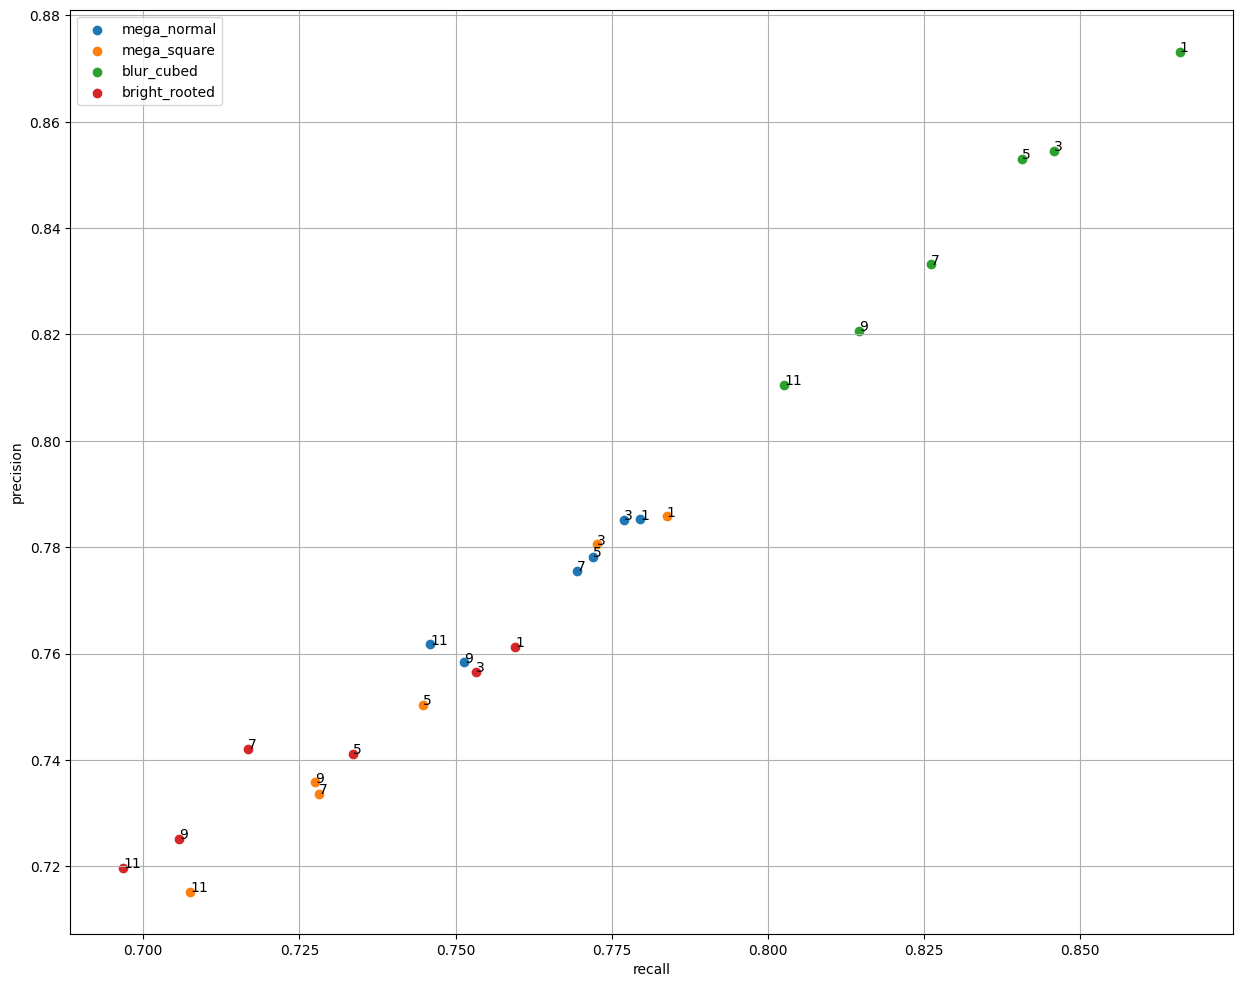

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

for model in table["model"].unique():
    sub = table[table["model"] == model]
    plt.scatter(sub["test_recall"], sub["test_precision"], label=model)
    for _, row in sub.iterrows():
        plt.text(row["test_recall"], row["test_precision"], str(row["k"]), fontsize=10)

plt.legend()
plt.ylabel("precision")
plt.xlabel("recall")
plt.grid(True)
plt.show()


In [ ]:
table.to_excel("knn_res.xlsx", index=False)

PCA Visualization

In [42]:
X_train_norm = StandardScaler().fit_transform(X_train)
X_train_pca = PCA(pca).fit_transform(X_train_norm) # pca selected was 75

In [43]:
X_train_norm.shape

(2416, 49152)

In [46]:
X_train_pca.shape # reduced from 49000+ features to just 75 features!

(2416, 75)

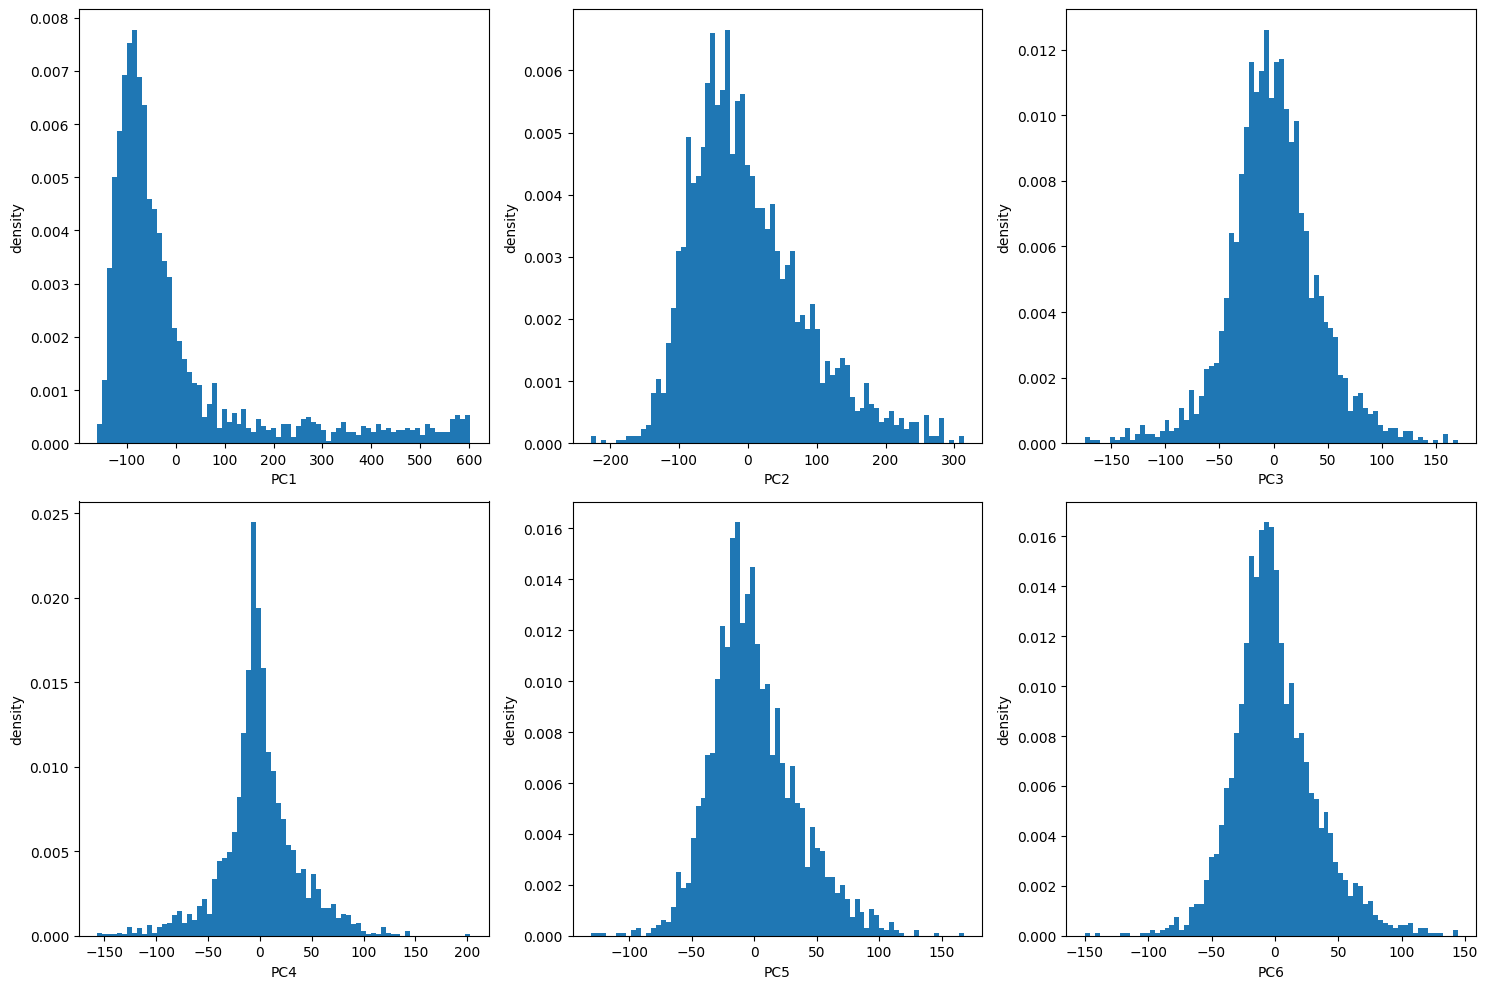

In [74]:
plt.figure(figsize=(15, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(X_train_pca[:, i], 75, density=True)
    plt.xlabel("PC" + str(i+1))
    plt.ylabel("density")

plt.tight_layout()
plt.show()